In [13]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import MaxNLocator

import feather

from tqdm import tqdm_notebook as tqdm

from tqdm import tqdm_pandas

from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

from multiprocessing import Pool

## Loading and setting up the data

In [2]:
se = feather.read_dataframe("../data_files/B/once/75days/stop_events_with_geo_train_test_averages_prev_next_dwell.feather")
se = se.set_index(se.columns[0])

In [3]:
 # And now for just segments:
se["diff_segment_and_mean_by_segment_code"] = (
    se["segment_duration"]
    - se["mean_durations_by_segment_code"]
)
se["diff_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    se["segment_duration"]
    - se["mean_durations_by_segment_code_and_hour_and_day"]
)

se["diff_percent_segment_and_mean_by_segment_code"] = (
    se["diff_segment_and_mean_by_segment_code"]
    * 100
    / se["mean_durations_by_segment_code"]
)

se["diff_percent_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    se["diff_segment_and_mean_by_segment_code_and_hour_and_day"]
    * 100
    / se["mean_durations_by_segment_code_and_hour_and_day"]
)

In [317]:
# se_min = se.iloc[0:1000, :].copy()

In [ ]:
# We need to generate this from scratch as we need both test and train data.
# ts_5 = se.pivot_table(
#     index="actualArrival",
#     columns="segment_code",
#     values="diff_percent_segment_and_mean_by_segment_code_and_hour_and_day",
#     aggfunc=np.median,
# )

In [4]:
# From: https://stackoverflow.com/questions/31661604/efficiently-create-sparse-pivot-tables-in-pandas

arrival_c = CategoricalDtype(sorted(se.actualArrival.unique()), ordered=True)
segment_code_c = CategoricalDtype(sorted(se.segment_code.unique()), ordered=True)

row = se.actualArrival.astype(arrival_c).cat.codes
col = se.segment_code.astype(segment_code_c).cat.codes
sparse_matrix = csr_matrix((se["diff_percent_segment_and_mean_by_segment_code_and_hour_and_day"], (row, col)), \
                           shape=(arrival_c.categories.size, segment_code_c.categories.size))

# # >>> sparse_matrix
# # <3x4 sparse matrix of type '<class 'numpy.int64'>'
# #      with 6 stored elements in Compressed Sparse Row format>

# # >>> sparse_matrix.todense()
# # matrix([[0, 1, 0, 1],
# #         [1, 0, 0, 1],
# #         [1, 0, 1, 0]], dtype=int64)


# ts = pd.SparseDataFrame(sparse_matrix, \
#                          index=arrival_c.categories, \
#                          columns=segment_code_c.categories, \
#                          default_fill_value=np.nan)
# # >>> dfs
# #         a   b   c   d
# #  him    0   1   0   1
# #   me    1   0   0   1
# #  you    1   0   1   0


In [160]:
# ts.loc['2018-12-16 14:00:00':'2018-12-16 14:08:01', '1200BOB20146_1200DOY38562_0'].dropna().mean()

-36.61971830985915

In [119]:
# tqdm_pandas(tqdm())

# print(len(se))

# def get_last_30(row):
#     journeys = ts.loc[row['actualArrival'] - pd.Timedelta("30 min"):row['actualArrival'] - pd.Timedelta("1 sec"), row['segment_code']].dropna()
    
#     return journeys.mean(), journeys.count()
    
# se['last_30_mins_mean'], se['last_30_mins_count'] = zip(*se.progress_apply(get_last_30, axis=1))
                                           


3920087


In [173]:
# pd.to_datetime(arrival_c.categories).slice_indexer('2018-12-16 14:00:00','2018-12-16 14:08:01')

slice(2667278, 2667464, None)

In [175]:
# sobj.start
# sobj.stop

2667464

In [146]:
# segment_code_c.categories.get_loc('1200BOB20146_1200DOY38562_0')

9

In [145]:
# segment_code_c.categories[9]

'1200BOB20146_1200DOY38562_0'

In [159]:
# sparse_matrix[2667278:2667464,9].data.mean()

-36.61971830985915

In [180]:
# print(len(se))

# arrival_index = pd.to_datetime(arrival_c.categories)
# segment_code_index = segment_code_c.categories

# last_15_mins_mean = np.empty(se.shape[0]).astype(float)
# last_15_mins_count = np.empty(se.shape[0]).astype(int)
# last_15_30_mins_mean = np.empty(se.shape[0]).astype(float)
# last_15_30_mins_count = np.empty(se.shape[0]).astype(int)
# last_30_45_mins_mean = np.empty(se.shape[0]).astype(float)
# last_30_45_mins_count = np.empty(se.shape[0]).astype(int)
# last_45_60_mins_mean = np.empty(se.shape[0]).astype(float)
# last_45_60_mins_count = np.empty(se.shape[0]).astype(int)

# def get_recent_buses(row, idx):
    
#     # 1800 seconds is 30 minutes, 1801 is 30 minutes and 1 second. 
#     slice_obj_15 = arrival_index.slice_indexer(row['actualArrival'] - pd.Timedelta("15 min"), row['actualArrival'] - pd.Timedelta("1 sec"))
#     slice_obj_15_30 = arrival_index.slice_indexer(row['actualArrival'] - pd.Timedelta("30 min"), row['actualArrival'] - pd.Timedelta("901 sec"))
#     slice_obj_30_45 = arrival_index.slice_indexer(row['actualArrival'] - pd.Timedelta("45 min"), row['actualArrival'] - pd.Timedelta("1801 sec"))
#     slice_obj_45_60 = arrival_index.slice_indexer(row['actualArrival'] - pd.Timedelta("60 min"), row['actualArrival'] - pd.Timedelta("2701 sec"))
    
#     column_index = segment_code_c.categories.get_loc(row['segment_code'])
    
#     journeys = sparse_matrix[slice_obj_15,column_index].data
    
#     last_15_mins_mean[idx] = journeys.mean()
#     last_15_mins_count[idx] = journeys.shape[0]
    
#     journeys = sparse_matrix[slice_obj_15_30,column_index].data
    
#     last_15_30_mins_mean[idx] = journeys.mean()
#     last_15_30_mins_count[idx] = journeys.shape[0]
    
#     journeys = sparse_matrix[slice_obj_30_45,column_index].data
    
#     last_30_45_mins_mean[idx] = journeys.mean()
#     last_30_45_mins_count[idx] = journeys.shape[0]
    
#     journeys = sparse_matrix[slice_obj_45_60,column_index].data
    
#     last_45_60_mins_mean[idx] = journeys.mean()
#     last_45_60_mins_count[idx] = journeys.shape[0]
    
# for idx, (_, row) in tqdm(enumerate(se[['actualArrival', 'segment_code']].iterrows())):
#     get_recent_buses(row, idx)
    
# se['last_15_mins_mean'] = last_15_mins_mean
# se['last_15_mins_count'] = last_15_mins_count 
# se['last_15_30_mins_mean'] = last_15_30_mins_mean 
# se['last_15_30_mins_count'] = last_15_30_mins_count
# se['last_30_45_mins_mean'] = last_30_45_mins_mean 
# se['last_30_45_mins_count'] = last_30_45_mins_count
# se['last_45_60_mins_mean'] = last_45_60_mins_mean 
# se['last_45_60_mins_count'] = last_45_60_mins_count
                   

3920087


/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice.
/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice.
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice.
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice.


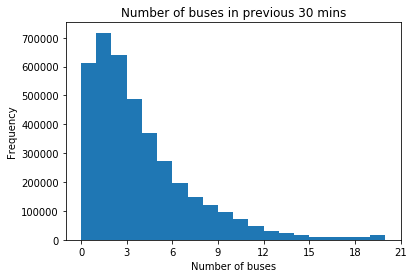

In [238]:
# ax = plt.figure().gca()
# ax.hist(se['last_30_mins_count'], bins=20, range=(0,20));
# plt.xlabel("Number of buses")
# plt.ylabel("Frequency")
# plt.title("Number of buses in previous 30 mins")

# ax.xaxis.set_major_locator(MaxNLocator(integer=True))


In [181]:
# se.reset_index().to_feather("with_last_slots.feather")


In [189]:
# print(len(se))

# arrival_index = pd.to_datetime(arrival_c.categories)
# segment_code_index = segment_code_c.categories

# last_15_mins_mean = np.empty(se.shape[0]).astype(float)
# last_15_mins_count = np.zeros(se.shape[0]).astype(int)
# last_15_30_mins_mean = np.empty(se.shape[0]).astype(float)
# last_15_30_mins_count = np.zeros(se.shape[0]).astype(int)
# last_30_45_mins_mean = np.empty(se.shape[0]).astype(float)
# last_30_45_mins_count = np.zeros(se.shape[0]).astype(int)
# last_45_60_mins_mean = np.empty(se.shape[0]).astype(float)
# last_45_60_mins_count = np.zeros(se.shape[0]).astype(int)

# last_15_mins_mean[:] = np.nan
# last_15_30_mins_mean[:] = np.nan
# last_30_45_mins_mean[:] = np.nan
# last_45_60_mins_mean[:] = np.nan


# def get_recent_buses(row, idx):
    
#     # 1800 seconds is 30 minutes, 1801 is 30 minutes and 1 second. 
#     slice_obj_15 = arrival_index.slice_indexer(row['actualArrival'] - pd.Timedelta("15 min"), row['actualArrival'] - pd.Timedelta("1 sec"))
#     slice_obj_15_30 = arrival_index.slice_indexer(row['actualArrival'] - pd.Timedelta("30 min"), row['actualArrival'] - pd.Timedelta("901 sec"))
#     slice_obj_30_45 = arrival_index.slice_indexer(row['actualArrival'] - pd.Timedelta("45 min"), row['actualArrival'] - pd.Timedelta("1801 sec"))
#     slice_obj_45_60 = arrival_index.slice_indexer(row['actualArrival'] - pd.Timedelta("60 min"), row['actualArrival'] - pd.Timedelta("2701 sec"))
    
#     try:
#         column_index = segment_code_index.get_loc(row['prev_segment_code_1'])
#     except KeyError:
#         return
    
#     journeys = sparse_matrix[slice_obj_15,column_index].data
    
#     last_15_mins_mean[idx] = journeys.mean()
#     last_15_mins_count[idx] = journeys.shape[0]
    
#     journeys = sparse_matrix[slice_obj_15_30,column_index].data
    
#     last_15_30_mins_mean[idx] = journeys.mean()
#     last_15_30_mins_count[idx] = journeys.shape[0]
    
#     journeys = sparse_matrix[slice_obj_30_45,column_index].data
    
#     last_30_45_mins_mean[idx] = journeys.mean()
#     last_30_45_mins_count[idx] = journeys.shape[0]
    
#     journeys = sparse_matrix[slice_obj_45_60,column_index].data
    
#     last_45_60_mins_mean[idx] = journeys.mean()
#     last_45_60_mins_count[idx] = journeys.shape[0]
    
# for idx, (_, row) in tqdm(enumerate(se[['actualArrival', 'prev_segment_code_1']].iterrows())):
#     get_recent_buses(row, idx)
    
# se['prev_segm_last_15_mins_mean'] = last_15_mins_mean
# se['prev_segm_last_15_mins_count'] = last_15_mins_count 
# se['prev_segm_last_15_30_mins_mean'] = last_15_30_mins_mean 
# se['prev_segm_last_15_30_mins_count'] = last_15_30_mins_count
# se['prev_segm_last_30_45_mins_mean'] = last_30_45_mins_mean 
# se['prev_segm_last_30_45_mins_count'] = last_30_45_mins_count
# se['prev_segm_last_45_60_mins_mean'] = last_45_60_mins_mean 
# se['prev_segm_last_45_60_mins_count'] = last_45_60_mins_count

3920087


/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice.
/Users/tommelamed/.local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice.
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice.
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: Mean of empty slice.


In [190]:
# print(len(se))

# arrival_index = pd.to_datetime(arrival_c.categories)
# segment_code_index = segment_code_c.categories

# last_15_mins_mean = np.empty(se.shape[0]).astype(float)
# last_15_mins_count = np.zeros(se.shape[0]).astype(int)
# last_15_30_mins_mean = np.empty(se.shape[0]).astype(float)
# last_15_30_mins_count = np.zeros(se.shape[0]).astype(int)
# last_30_45_mins_mean = np.empty(se.shape[0]).astype(float)
# last_30_45_mins_count = np.zeros(se.shape[0]).astype(int)
# last_45_60_mins_mean = np.empty(se.shape[0]).astype(float)
# last_45_60_mins_count = np.zeros(se.shape[0]).astype(int)

# last_15_mins_mean[:] = np.nan
# last_15_30_mins_mean[:] = np.nan
# last_30_45_mins_mean[:] = np.nan
# last_45_60_mins_mean[:] = np.nan

# def get_recent_buses(row, idx):
    
#     # 1800 seconds is 30 minutes, 1801 is 30 minutes and 1 second. 
#     slice_obj_15 = arrival_index.slice_indexer(row['actualArrival'] - pd.Timedelta("15 min"), row['actualArrival'] - pd.Timedelta("1 sec"))
#     slice_obj_15_30 = arrival_index.slice_indexer(row['actualArrival'] - pd.Timedelta("30 min"), row['actualArrival'] - pd.Timedelta("901 sec"))
#     slice_obj_30_45 = arrival_index.slice_indexer(row['actualArrival'] - pd.Timedelta("45 min"), row['actualArrival'] - pd.Timedelta("1801 sec"))
#     slice_obj_45_60 = arrival_index.slice_indexer(row['actualArrival'] - pd.Timedelta("60 min"), row['actualArrival'] - pd.Timedelta("2701 sec"))
    
#     try:
#         column_index = segment_code_index.get_loc(row['next_segment_code_1'])
#     except KeyError:
#         return
    
#     journeys = sparse_matrix[slice_obj_15,column_index].data
    
#     last_15_mins_mean[idx] = journeys.mean()
#     last_15_mins_count[idx] = journeys.shape[0]
    
#     journeys = sparse_matrix[slice_obj_15_30,column_index].data
    
#     last_15_30_mins_mean[idx] = journeys.mean()
#     last_15_30_mins_count[idx] = journeys.shape[0]
    
#     journeys = sparse_matrix[slice_obj_30_45,column_index].data
    
#     last_30_45_mins_mean[idx] = journeys.mean()
#     last_30_45_mins_count[idx] = journeys.shape[0]
    
#     journeys = sparse_matrix[slice_obj_45_60,column_index].data
    
#     last_45_60_mins_mean[idx] = journeys.mean()
#     last_45_60_mins_count[idx] = journeys.shape[0]
    
# for idx, (_, row) in tqdm(enumerate(se[['actualArrival', 'next_segment_code_1']].iterrows())):
#     get_recent_buses(row, idx)
    
# se['next_segm_last_15_mins_mean'] = last_15_mins_mean
# se['next_segm_last_15_mins_count'] = last_15_mins_count 
# se['next_segm_last_15_30_mins_mean'] = last_15_30_mins_mean 
# se['next_segm_last_15_30_mins_count'] = last_15_30_mins_count
# se['next_segm_last_30_45_mins_mean'] = last_30_45_mins_mean 
# se['next_segm_last_30_45_mins_count'] = last_30_45_mins_count
# se['next_segm_last_45_60_mins_mean'] = last_45_60_mins_mean 
# se['next_segm_last_45_60_mins_count'] = last_45_60_mins_count

3920087


/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: Mean of empty slice.
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice.
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice.
/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice.


In [14]:
num_partitions = 20 #number of partitions to split dataframe
num_cores = 6 #number of cores on your machine

def parallelize_dataframe(df, func, args):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    
    # This line is fidly, we make a list where each item is a tuple of 
    # a bit of the dataframe and whatever is passed in as args. 
    # Then starmap unpacks that tuple so each copy of func gets it's 
    # little bit of the dataframe and the right args to do it's job. 
    # All this to avoid globals! 
    all_args = [(split,) + args for split in df_split]
    
    df = pd.concat(pool.starmap(func, all_args))
    pool.close()
    pool.join()
    return df

In [16]:
def calc_segment(se, segment, window_count, window_size = 5):
    
    arrival_index = pd.to_datetime(arrival_c.categories)
    segment_code_index = segment_code_c.categories
    
    last_time_slots_mean = np.empty((se.shape[0], window_count)).astype(float)
    last_time_slots_count = np.zeros((se.shape[0], window_count)).astype(int)
    
    last_time_slots_mean[:,:] = np.nan

    def get_recent_buses(row, idx):
        
        try:
            column_index = segment_code_index.get_loc(row[2])
        except KeyError:
            return

        slices = []
        for i in range(window_count):
            slice_obj = arrival_index.slice_indexer(row[1] - (i+1) * pd.Timedelta(f"{window_size} min"), 
                                                      row[1] - (i * pd.Timedelta(f"{window_size} min")) + pd.Timedelta("1 sec"))


            journeys = sparse_matrix[slice_obj,column_index].data
            
            if journeys.shape[0] == 0:
                continue

            last_time_slots_mean[idx, i] = journeys.mean()
            last_time_slots_count[idx, i] = journeys.shape[0]

    
    for idx, row in tqdm(enumerate(se[['actualArrival', segment]].itertuples()), total=se.shape[0]):
        get_recent_buses(row, idx)
        

    se[f'{segment}_last_{window_count}_{window_size}mins_means'] = last_time_slots_mean.tolist()
    se[f'{segment}_last_{window_count}_{window_size}mins_counts'] = last_time_slots_count.tolist()
    
    return se



In [17]:
# calc_segment(se, 'segment_code', 12, 15)

se = parallelize_dataframe(se, calc_segment, ('segment_code', 12, 15))

In [ ]:
se = parallelize_dataframe(se, calc_segment, ('next_segment_code_1', 12, 15))
print("*", flush=True)
se = parallelize_dataframe(se, calc_segment, ('next_segment_code_2', 12, 15))
print("*", flush=True)
se = parallelize_dataframe(se, calc_segment, ('next_segment_code_3', 12, 15))
print("*", flush=True)
se = parallelize_dataframe(se, calc_segment, ('prev_segment_code_1', 12, 15))
print("*", flush=True)
se = parallelize_dataframe(se, calc_segment, ('prev_segment_code_2', 12, 15))
print("*", flush=True)
se = parallelize_dataframe(se, calc_segment, ('prev_segment_code_3', 12, 15))
print("*", flush=True)

*
*
*
*
*


In [ ]:
# calc_segment(se, 'next_segment_code_1', 8, 15)

In [ ]:
# calc_segment(se, 'prev_segment_code_1', 8, 15)

In [ ]:
# calc_segment(se, 'prev_segment_code_2', 6, 15)

In [ ]:
# calc_segment(se, 'next_segment_code_2', 6, 15)

In [ ]:
# calc_segment(se, 'next_segment_code_3', 6, 15)

In [ ]:
# calc_segment(se, 'prev_segment_code_3', 6, 15)

In [ ]:
se.reset_index().to_feather("with_last_slots2.feather")

In [198]:
se_min = se.iloc[0:100000, :].copy()

In [199]:
se_min['mean_offsets_enhanced_all'] = 0

mask = np.sum(se_min[['last_15_mins_count', 
                                                        'last_15_30_mins_count', 
                                                        'last_30_45_mins_count',
                                                        'last_45_60_mins_count',
                                                       'prev_segm_last_15_mins_count', 
                                                        'prev_segm_last_15_30_mins_count', 
                                                        'prev_segm_last_30_45_mins_count',
                                                        'prev_segm_last_45_60_mins_count',
                                                       'next_segm_last_15_mins_count', 
                                                        'next_segm_last_15_30_mins_count', 
                                                        'next_segm_last_30_45_mins_count',
                                                        'next_segm_last_45_60_mins_count']], axis=1) > 0

data = se_min.loc[mask, ['last_15_mins_mean', 
                                                        'last_15_30_mins_mean', 
                                                        'last_30_45_mins_mean',
                                                        'last_45_60_mins_mean',
                                                       'prev_segm_last_15_mins_mean', 
                                                        'prev_segm_last_15_30_mins_mean', 
                                                        'prev_segm_last_30_45_mins_mean',
                                                        'prev_segm_last_45_60_mins_mean',
                                                       'next_segm_last_15_mins_mean', 
                                                        'next_segm_last_15_30_mins_mean', 
                                                        'next_segm_last_30_45_mins_mean',
                                                        'next_segm_last_45_60_mins_mean']]

weights = se_min.loc[mask, ['last_15_mins_count', 
                                                        'last_15_30_mins_count', 
                                                        'last_30_45_mins_count',
                                                        'last_45_60_mins_count',
                                                       'prev_segm_last_15_mins_count', 
                                                        'prev_segm_last_15_30_mins_count', 
                                                        'prev_segm_last_30_45_mins_count',
                                                        'prev_segm_last_45_60_mins_count',
                                                       'next_segm_last_15_mins_count', 
                                                        'next_segm_last_15_30_mins_count', 
                                                        'next_segm_last_30_45_mins_count',
                                                        'next_segm_last_45_60_mins_count']]

masked_data = np.ma.masked_array(data, np.isnan(data))

se_min.loc[mask, 'mean_offsets_enhanced_all'] = np.ma.average(masked_data, 
                                               axis=1,
                                               weights=weights)



In [297]:
se_min['mean_offsets_enhanced_15plus'] = 0

mask = np.sum(se_min[[
                                                        'last_15_30_mins_count', 
                                                        'last_30_45_mins_count',
                                                        'last_45_60_mins_count',
                                                       
                                                        'prev_segm_last_15_30_mins_count', 
                                                        'prev_segm_last_30_45_mins_count',
                                                        'prev_segm_last_45_60_mins_count',
                                                       
                                                        'next_segm_last_15_30_mins_count', 
                                                        'next_segm_last_30_45_mins_count',
                                                        'next_segm_last_45_60_mins_count']], axis=1) > 0

data = se_min.loc[mask, [
                                                        'last_15_30_mins_mean', 
                                                        'last_30_45_mins_mean',
                                                        'last_45_60_mins_mean',
                                                      
                                                        'prev_segm_last_15_30_mins_mean', 
                                                        'prev_segm_last_30_45_mins_mean',
                                                        'prev_segm_last_45_60_mins_mean',
                                                       
                                                        'next_segm_last_15_30_mins_mean', 
                                                        'next_segm_last_30_45_mins_mean',
                                                        'next_segm_last_45_60_mins_mean']]

weights = se_min.loc[mask, [
                                                        'last_15_30_mins_count', 
                                                        'last_30_45_mins_count',
                                                        'last_45_60_mins_count',
                                                      
                                                        'prev_segm_last_15_30_mins_count', 
                                                        'prev_segm_last_30_45_mins_count',
                                                        'prev_segm_last_45_60_mins_count',
                                                      
                                                        'next_segm_last_15_30_mins_count', 
                                                        'next_segm_last_30_45_mins_count',
                                                        'next_segm_last_45_60_mins_count']]

masked_data = np.ma.masked_array(data, np.isnan(data))

se_min.loc[mask, 'mean_offsets_enhanced_15plus'] = np.ma.average(masked_data, 
                                               axis=1,
                                               weights=weights)



In [305]:
se_min['mean_offsets_enhanced_15plus_filtered'] = 0

mask = np.sum(se_min[[
                                                        'last_15_30_mins_count', 
                                                        'last_30_45_mins_count',
                                                        'last_45_60_mins_count',
                                                       
                                                        'prev_segm_last_15_30_mins_count', 
                                                        'prev_segm_last_30_45_mins_count',
                                                        'prev_segm_last_45_60_mins_count',
                                                       
                                                        'next_segm_last_15_30_mins_count', 
                                                        'next_segm_last_30_45_mins_count',
                                                        'next_segm_last_45_60_mins_count']], axis=1) > 10

data = se_min.loc[mask, [
                                                        'last_15_30_mins_mean', 
                                                        'last_30_45_mins_mean',
                                                        'last_45_60_mins_mean',
                                                      
                                                        'prev_segm_last_15_30_mins_mean', 
                                                        'prev_segm_last_30_45_mins_mean',
                                                        'prev_segm_last_45_60_mins_mean',
                                                       
                                                        'next_segm_last_15_30_mins_mean', 
                                                        'next_segm_last_30_45_mins_mean',
                                                        'next_segm_last_45_60_mins_mean']]

weights = se_min.loc[mask, [
                                                        'last_15_30_mins_count', 
                                                        'last_30_45_mins_count',
                                                        'last_45_60_mins_count',
                                                      
                                                        'prev_segm_last_15_30_mins_count', 
                                                        'prev_segm_last_30_45_mins_count',
                                                        'prev_segm_last_45_60_mins_count',
                                                      
                                                        'next_segm_last_15_30_mins_count', 
                                                        'next_segm_last_30_45_mins_count',
                                                        'next_segm_last_45_60_mins_count']]

masked_data = np.ma.masked_array(data, np.isnan(data))

se_min.loc[mask, 'mean_offsets_enhanced_15plus_filtered'] = np.ma.average(masked_data, 
                                               axis=1,
                                               weights=weights)



In [240]:
bus_counts = np.sum(se_min[['last_15_mins_count', 
                                                        'last_15_30_mins_count', 
                                                        'last_30_45_mins_count',
                                                        'last_45_60_mins_count',
                                                       'prev_segm_last_15_mins_count', 
                                                        'prev_segm_last_15_30_mins_count', 
                                                        'prev_segm_last_30_45_mins_count',
                                                        'prev_segm_last_45_60_mins_count',
                                                       'next_segm_last_15_mins_count', 
                                                        'next_segm_last_15_30_mins_count', 
                                                        'next_segm_last_30_45_mins_count',
                                                        'next_segm_last_45_60_mins_count']], axis=1)

Text(0.5, 1.0, 'Number of data points for last hour incl prev & next segments')

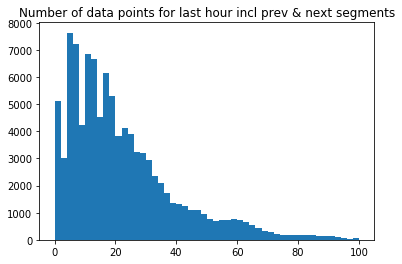

In [248]:
plt.hist(bus_counts, bins=50, range=(0,100));
plt.title("Number of data points for last hour incl prev & next segments")

In [200]:
se_min['mean_offsets_enhanced_all']

index
0         26.921840
1         28.093833
2         33.135134
3         16.057345
4         10.811433
5        -15.126887
6        -16.386823
7        -13.209030
8         -7.106021
9        -12.086098
10        -6.496803
11       -10.606828
12       -15.516421
13       -17.437506
14       -20.247728
15       -13.126383
16         7.136349
17        19.596094
18         7.787946
19        -1.650280
20       -16.512535
21         8.003074
22         6.503921
23         1.902389
24       -10.033343
25        -7.455893
26         5.690276
27         4.118043
28        -2.176149
29       -11.544159
            ...    
100119    -9.132651
100120   -25.937862
100121    18.867925
100122    68.750000
100123   -20.792079
100124    -4.736944
100125    35.096720
100126    19.807193
100127   -25.518904
100128   -56.441220
100129   -23.685070
100130     8.329142
100131    22.712049
100132    14.764445
100133     3.917099
100134    -3.588724
100135    -6.303298
100136   -23.219723
100137     6.2

In [211]:
se_min['mean_durations_by_segment_code_and_hour_and_day_enhanced_all'] = se_min['mean_durations_by_segment_code_and_hour_and_day'] * (1 + (se_min['mean_offsets_enhanced_all']/100))


In [298]:

se_min['mean_durations_by_segment_code_and_hour_and_day_enhanced_15plus'] = se_min['mean_durations_by_segment_code_and_hour_and_day'] * (1 + (se_min['mean_offsets_enhanced_15plus']/100))



In [306]:
se_min['mean_durations_by_segment_code_and_hour_and_day_enhanced_15plus_filtered'] = se_min['mean_durations_by_segment_code_and_hour_and_day'] * (1 + (se_min['mean_offsets_enhanced_15plus_filtered']/100))

In [212]:
se_min['mean_durations_by_segment_code_and_hour_and_day_enhanced_7'] = se_min['mean_durations_by_segment_code_and_hour_and_day']

se_min.loc[se_min['last_30_mins_count'] >= 7, 'mean_durations_by_segment_code_and_hour_and_day_enhanced_7'] = se_min.loc[se_min['last_30_mins_count'] >= 7, 'mean_durations_by_segment_code_and_hour_and_day'] * (1 + (se_min.loc[se_min['last_30_mins_count'] >= 7, 'last_30_mins_mean']/100))



In [213]:
for i in range(10):
    print(f"{i} -> {np.count_nonzero(se_min['last_30_mins_count'] >= i)/len(se_min)*100}%")

0 -> 100.0%
1 -> 82.799%
2 -> 64.57300000000001%
3 -> 48.063%
4 -> 35.385%
5 -> 26.207%
6 -> 19.375999999999998%
7 -> 14.402999999999999%
8 -> 10.786999999999999%
9 -> 8.019%


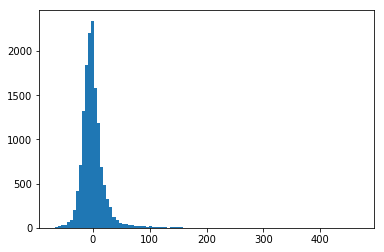

In [214]:
plt.hist(se_min.loc[se_min['last_30_mins_count'] >= 7, 'last_30_mins_mean'], bins=100);

In [307]:
predict_array_median_chd = np.empty((se_min.shape[0],140)).astype(float)
predict_array_median_chd[:] = np.nan

predict_array_mean_chd = np.empty((se_min.shape[0],140)).astype(float)
predict_array_mean_chd[:] = np.nan

predict_array_mean_enh = np.empty((se_min.shape[0],140)).astype(float)
predict_array_mean_enh[:] = np.nan

predict_array_mean_enh7 = np.empty((se_min.shape[0],140)).astype(float)
predict_array_mean_enh7[:] = np.nan

predict_array_mean_enh_all = np.empty((se_min.shape[0],140)).astype(float)
predict_array_mean_enh_all[:] = np.nan

predict_array_mean_enh_15plus = np.empty((se_min.shape[0],140)).astype(float)
predict_array_mean_enh_15plus[:] = np.nan

predict_array_mean_enh_15plus_filtered = np.empty((se_min.shape[0],140)).astype(float)
predict_array_mean_enh_15plus_filtered[:] = np.nan

predict_array_median_rules = np.empty((se_min.shape[0],140)).astype(float)
predict_array_median_rules[:] = np.nan

predict_array_mean_rules = np.empty((se_min.shape[0],140)).astype(float)
predict_array_mean_rules[:] = np.nan

actual_array = np.empty((se_min.shape[0],140)).astype(float)
actual_array[:] = np.nan

In [216]:
# Rest the index so that it matches the index into the numpy array

se_min.reset_index(drop=True, inplace=True)

In [217]:
runs = se_min.groupby(['date','workid'])

In [308]:
for name, run in tqdm(runs):
    run = run.sort_values("actualArrival")
    
    run_length = len(run)
    
    for i in range(min([run_length, 70])):
        
        predict_array_median_chd[run.iloc[i:].index,i*2:i*2+2] = run.iloc[:run_length-i][['median_durations_by_segment_code_and_hour_and_day', 'median_dwell_prev_by_stop_code_and_hour_and_day']]
        
        predict_array_mean_chd[run.iloc[i:].index,i*2:i*2+2] = run.iloc[:run_length-i][['mean_durations_by_segment_code_and_hour_and_day', 'mean_dwell_prev_by_stop_code_and_hour_and_day']]
        
#         predict_array_mean_enh[run.iloc[i:].index,i*2:i*2+2] = run.iloc[:run_length-i][['mean_durations_by_segment_code_and_hour_and_day_enhanced', 'median_dwell_prev_durations_by_stop_code']]
        
#         predict_array_mean_enh7[run.iloc[i:].index,i*2:i*2+2] = run.iloc[:run_length-i][['mean_durations_by_segment_code_and_hour_and_day_enhanced_7', 'mean_dwell_prev_durations_by_stop_code']]
        
        predict_array_mean_enh_all[run.iloc[i:].index,i*2:i*2+2] = run.iloc[:run_length-i][['mean_durations_by_segment_code_and_hour_and_day_enhanced_all', 'mean_dwell_prev_durations_by_stop_code']]
        
        predict_array_mean_enh_15plus[run.iloc[i:].index,i*2:i*2+2] = run.iloc[:run_length-i][['mean_durations_by_segment_code_and_hour_and_day_enhanced_15plus', 'mean_dwell_prev_durations_by_stop_code']]
        
        predict_array_mean_enh_15plus_filtered[run.iloc[i:].index,i*2:i*2+2] = run.iloc[:run_length-i][['mean_durations_by_segment_code_and_hour_and_day_enhanced_15plus_filtered', 'mean_dwell_prev_durations_by_stop_code']]
        
#         predict_array_median_rules[run.iloc[i:].index,i*2:i*2+2] = run.iloc[:run_length-i][['mean_durations_by_segment_code', 'dwell_predict_rules_median']]
        
#         predict_array_mean_rules[run.iloc[i:].index,i*2:i*2+2] = run.iloc[:run_length-i][['mean_durations_by_segment_code', 'dwell_predict_rules_mean']]
    
        actual_array[run.iloc[i:].index,i*2:i*2+2] = run.iloc[:run_length-i][['segment_duration', 'dwell_duration_prev']]
        

In [ ]:
nans = []

for i in range(140):
    nans.append(predict_array_median_chd.shape[0] - np.count_nonzero(np.isnan(predict_array_median_chd[:,i])))
    
plt.plot(nans)

In [275]:
def percent_in_x_percent(predict, actual, threshold):
    
    if np.count_nonzero(~np.isnan(actual)) == 0:
        return 0
    
    threshold = threshold/100
    
    mask = (~np.isnan(predict) & ~np.isnan(actual))
    
    pass_count = np.count_nonzero((predict[mask] < actual[mask] * (1 + threshold)) & (predict[mask] > actual[mask] * (1-threshold)))
    
    over_count = np.count_nonzero(predict[mask] > actual[mask] * (1+threshold))
    
    under_count = np.count_nonzero(predict[mask] < actual[mask] * (1-threshold))
    
    pass_percent = pass_count/np.count_nonzero(mask) * 100
    
    if over_count + under_count == 0:
        drift = 0.5
    else:
        drift = over_count / (over_count + under_count)
    
    return pass_percent, drift

In [276]:
def make_accuracy_matrix_minutes(predict, actual, max_threshold = 50):

    actual_ints = np.array(actual/60).astype(int)
    
    rows = int(max_threshold/10)
    
    max_a = np.nanmax(actual)/60

    accuracies_table = np.empty((rows, int(max_a)))
    drift_table = np.empty((rows, int(max_a)))
    frequency = np.empty(int(max_a))

    for i in range(int(max_a)):
        print(".", end="", flush=True)
        mask = (actual_ints == i)
        
        frequency[i] = np.count_nonzero(mask)
        
        for j in range(1, rows+1):
            accuracy, drift = percent_in_x_percent(predict[mask], actual[mask], j * 10)
            accuracies_table[j-1,i] = accuracy
            drift_table[j-1, i] = drift

    return accuracies_table, frequency, drift_table

In [284]:
def show_accuracy_minutes(predict, actual, title):
    results, frequency, drift = make_accuracy_matrix_minutes(predict, actual)
    
    for i in range(results.shape[0]):
        plt.plot(results[i,:], label=f"{(i+1)*10}%")
        
        
    plt.xlabel("minutes ahead")
    plt.ylabel("percentage within threshold")
    plt.legend()
    plt.title(title)
    plt.xlim(0,20)
    plt.ylim(0,100)
    plt.gca().yaxis.grid(True, linewidth="0.2")
    
    ax = plt.gca()
    
    ax2 = ax.twinx()
    ax2.plot(drift[0,:], label="fraction over", linestyle=":")
    ax2.set_ylim(0,1)
   
    plt.show()

In [309]:
predict_array_median_chd_cum = np.cumsum(predict_array_median_chd, axis=1)
predict_array_mean_chd_cum = np.cumsum(predict_array_mean_chd, axis=1)
# predict_array_mean_enh_cum = np.cumsum(predict_array_mean_enh, axis=1)
# predict_array_mean_enh7_cum = np.cumsum(predict_array_mean_enh7, axis=1)
predict_array_mean_enh_all_cum = np.cumsum(predict_array_mean_enh_all, axis=1)
predict_array_mean_enh_15plus_cum = np.cumsum(predict_array_mean_enh_15plus, axis=1)
predict_array_mean_enh_15plus_filtered_cum = np.cumsum(predict_array_mean_enh_15plus_filtered, axis=1)
# predict_array_median_rules_cum = np.cumsum(predict_array_median_rules, axis=1)
# predict_array_mean_rules_cum = np.cumsum(predict_array_mean_rules, axis=1)


actual_array_cum = np.cumsum(actual_array, axis=1)



In [310]:
predict_journey_median_chd_cum = np.cumsum(predict_array_median_chd[:, ::2], axis=1)
predict_journey_mean_chd_cum = np.cumsum(predict_array_mean_chd[:, ::2], axis=1)
# predict_journey_mean_enh_cum = np.cumsum(predict_array_mean_enh[:, ::2], axis=1)
# predict_journey_mean_enh7_cum = np.cumsum(predict_array_mean_enh7[:, ::2], axis=1)
predict_journey_mean_enh_all_cum = np.cumsum(predict_array_mean_enh_all[:, ::2], axis=1)
predict_journey_mean_enh_15plus_cum = np.cumsum(predict_array_mean_enh_15plus[:, ::2], axis=1)
predict_journey_mean_enh_15plus_filtered_cum = np.cumsum(predict_array_mean_enh_15plus_filtered[:, ::2], axis=1)
actual_journey_cum = np.clip(np.cumsum(actual_array[:, ::2], axis=1), 0, 2*60*60)

predict_dwell_median_chd_cum = np.cumsum(predict_array_median_chd[:, 1::2], axis=1)
predict_dwell_mean_chd_cum = np.cumsum(predict_array_mean_chd[:, 1::2], axis=1)
actual_dwell_cum = np.clip(np.cumsum(actual_array[:, 1::2], axis=1), 0, 2*60*60)

In [95]:
# predict_dwell_median_rules_cum = np.cumsum(predict_array_median_rules[:, 1::2], axis=1)
# predict_dwell_mean_rules_cum = np.cumsum(predict_array_mean_rules[:, 1::2], axis=1)

In [96]:
actual_array_cum = np.clip(actual_array_cum, 0, 2*60*60)

.................................................................................................

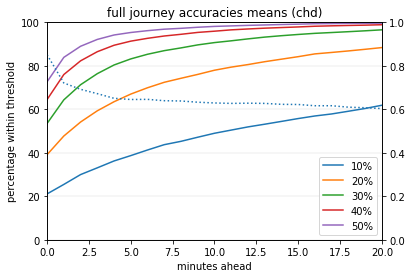

In [285]:
show_accuracy_minutes(predict_array_mean_chd_cum, actual_array_cum, "full journey accuracies means (chd)")

.................................................................................................

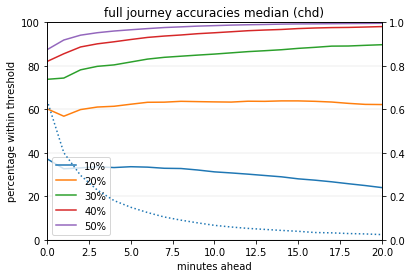

In [286]:
show_accuracy_minutes(predict_array_median_chd_cum, actual_array_cum, "full journey accuracies median (chd)")

.................................................................................................

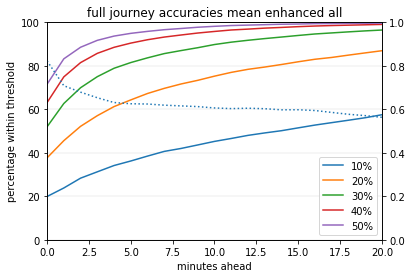

In [287]:
show_accuracy_minutes(predict_array_mean_enh_all_cum, actual_array_cum, "full journey accuracies mean enhanced all")


.................................................................................................

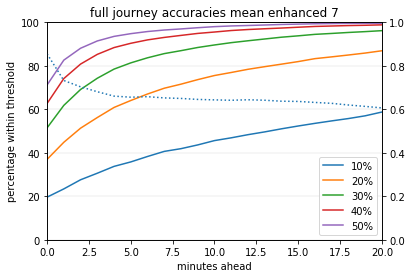

In [289]:
show_accuracy_minutes(predict_array_mean_enh7_cum, actual_array_cum, "full journey accuracies mean enhanced 7")

.........................................................................

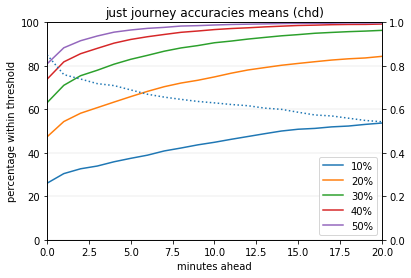

In [290]:
show_accuracy_minutes(predict_journey_mean_chd_cum, actual_journey_cum, "just journey accuracies means (chd)")


.........................................................................

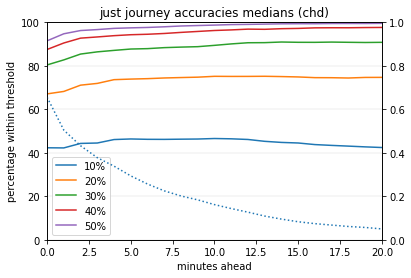

In [291]:
show_accuracy_minutes(predict_journey_median_chd_cum, actual_journey_cum, "just journey accuracies medians (chd)")

.........................................................................

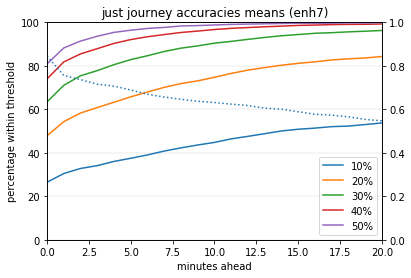

In [293]:
show_accuracy_minutes(predict_journey_mean_enh7_cum, actual_journey_cum, "just journey accuracies means (enh7)")

In [311]:
results, _, _= make_accuracy_matrix_minutes(predict_journey_mean_chd_cum, actual_journey_cum, 10)
results_enh7, _, _ = make_accuracy_matrix_minutes(predict_journey_mean_enh7_cum, actual_journey_cum, 10)
results_enh_all, _, _ = make_accuracy_matrix_minutes(predict_journey_mean_enh_all_cum, actual_journey_cum, 10)
results_enh_15plus, _, _ = make_accuracy_matrix_minutes(predict_journey_mean_enh_15plus_cum, actual_journey_cum, 10)
results_enh_15plus_filtered, _, _ = make_accuracy_matrix_minutes(predict_journey_mean_enh_15plus_filtered_cum, actual_journey_cum, 10)


.............................................................................................................................................................................................................................................................................................................................................................................

Text(0, 0.5, 'percent within 10%')

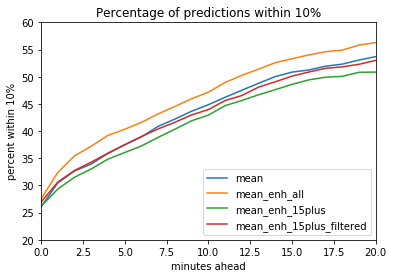

In [316]:
plt.plot(results[0,:], label="mean")
# plt.plot(results_enh7[0,:], label="mean_enh7")
plt.plot(results_enh_all[0,:], label="mean_enh_all")
plt.plot(results_enh_15plus[0,:], label="mean_enh_15plus")
plt.plot(results_enh_15plus_filtered[0,:], label="mean_enh_15plus_filtered")
plt.legend()
plt.xlim(0,20)
plt.ylim(20,60)
plt.title("Percentage of predictions within 10%")
plt.xlabel("minutes ahead")
plt.ylabel("percent within 10%")

21.115604832239693